In [1]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

import seaborn as sns

In [11]:
import sys
sys.path.append('/Users/dbao/Downloads/research/rc_scripts/analysis/final_analysis/')

from process_helper import *
from plot_helper import *
save_mode = ".pdf"
font_size = 18
color_palette = ["black", "grey"]

In [7]:
%load_ext rpy2.ipython

from rpy2.robjects.packages import importr
# import R's "base" package
lme4 = importr('lme4')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Load data

In [4]:
home_dir = '/Users/dbao/Library/CloudStorage/GoogleDrive-sherrydbao@gmail.com/.shortcut-targets-by-id/1sYZNVBbYCrHcHjo-9xdKcA4wLnob9ZEq/'+'/road_construction/data/2022_online/'
data_dir = home_dir + 'R_analysis_data/'
out_dir = home_dir + 'figures/figures_final/'
out_dir2 = home_dir + 'stat_model/final/'

In [5]:
data_choice_level = pd.read_csv(data_dir +  'choice_level/choicelevel_data.csv') # first column is index  
data_choice_level = data_choice_level.rename(columns={'Unnamed: 0':'index_copy'})
data_choice_level = df_choice_add_features(data_choice_level, add_first_move=0)
sc_data_choice_level = data_choice_level[data_choice_level['condition']==1].reset_index(drop=True) 

data_puzzle_level = pd.read_csv(data_dir +  'data.csv') # first column is subject
data_puzzle_level = df_map_add_features(data_puzzle_level, data_choice_level)
single_condition_data = data_puzzle_level[data_puzzle_level['condition']==1].copy()
single_condition_data = single_condition_data.reset_index(drop=True)

In [6]:
data_subset_before1undo = df_subset_1undo_submit(sc_data_choice_level)
state_undo_1undo = df_subset_1state(data_subset_before1undo, data_puzzle_level, single_condition_data, f"(firstUndo ==1)", 1)
state_notundo_1undo = df_subset_1state(data_subset_before1undo, data_puzzle_level, single_condition_data, f"(submit ==1)", 0)
state_df_1undo = pd.concat([state_undo_1undo,state_notundo_1undo])
state_df_1undo = state_df_1undo.reset_index(drop=True)

# Save state_df_1undo to csv
state_df_1undo.to_csv(data_dir + 'state_df_1undo.csv', index=False)

# only keep rows with RPE to be non-na
# state_df_1undo = state_df_1undo[state_df_1undo['RPE'].notna()]

# Task difficulty 

In [16]:
print(spearmanr(state_undo_1undo.groupby(['subjects'])['RT1'].mean() , state_undo_1undo.groupby(['subjects'])['RT1_basic'].mean()))

SpearmanrResult(correlation=0.7310721879113091, pvalue=2.892947862872251e-15)


In [8]:
print(spearmanr(state_undo_1undo[state_undo_1undo['cumulative_error']!=0].groupby(['subjects'])['RT1'].mean() , state_undo_1undo[state_undo_1undo['cumulative_error']!=0].groupby(['subjects'])['cumulative_error'].mean()))

SpearmanrResult(correlation=-0.13908081834707958, pvalue=0.20704262834781406)


## First-move RT

In [8]:
temp1, cutoff = pd.cut(state_df_1undo['RT1_log'], bins=5, labels=range(1,6),retbins=True)
state_df_1undo['rt1_bin'] = temp1.astype(int)
# temp2, cutoff = pd.cut(state_df_1undo['RT1_basic_log'], bins=5, labels=range(1,6),retbins=True)
# state_df_1undo['rt1_basic_bin'] = temp2.astype(int)

In [9]:
firstUndo_sub = state_df_1undo.groupby(['subjects','rt1_bin','error'])['firstUndo'].mean().reset_index()
firstUndo_sub.groupby(['rt1_bin','error'])['firstUndo'].count()

rt1_bin  error
1        False    92
         True     92
2        False    97
         True     99
3        False    54
         True     66
4        False     8
         True     16
5        False     1
         True      4
Name: firstUndo, dtype: int64

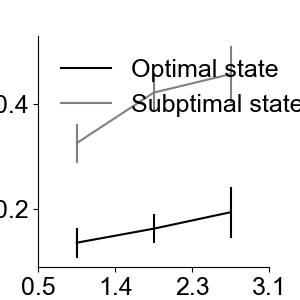

In [14]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(3, 3)
plt.rcParams.update({'font.size': font_size})

# multiple line plot    
sns.lineplot(x='rt1_bin', y='firstUndo', 
             data = firstUndo_sub[firstUndo_sub.rt1_bin<=3],
             hue = "error",
             palette = color_palette,
             err_style = "bars",
             errorbar = "se")

# only use 1 decimal place
cutoff_round = [round(i,1) for i in cutoff]
axs.set_xticks(np.arange(0.5, 4.5, 1))
axs.set_xticklabels(cutoff_round[:-2])
axs.legend(labels=['Optimal state','Subptimal state'], frameon=False, loc='upper left')

# hide legend
# axs.get_legend().remove()
# axs.set_ylim([0,0.2])
# axs.set_yticks(np.arange(0, 0.25, 0.05))
axs.set(xlabel='Log(First-move RT)', ylabel='Probability of Undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_first_rt'+save_mode, dpi=300, bbox_inches='tight')
plt.show()

In [20]:
%%R -i state_df_1undo,out_dir2
state_df_1undo$subjects <- as.factor(state_df_1undo[,"subjects"])
state_df_1undo$puzzleID <- as.factor(state_df_1undo[,"puzzleID"])
state_df_1undo$error <- as.factor(state_df_1undo[,"error"])

model_undo = lme4::glmer(firstUndo ~  1 + RT1_log*error + (1 |subjects)+(1|puzzleID),
                                  data = state_df_1undo, family = binomial(link="logit"))

# save(model_undo, state_df_1undo, file=file.path(out_dir2, file=paste("model_undo_rt1.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + RT1_log * error + (1 | subjects) + (1 | puzzleID)
   Data: state_df_1undo

     AIC      BIC   logLik deviance df.resid 
  3076.5   3114.5  -1532.3   3064.5     4152 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0456 -0.3686 -0.1465  0.0859 10.4130 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 6.9472   2.6358  
 puzzleID (Intercept) 0.5547   0.7448  
Number of obs: 4158, groups:  subjects, 100; puzzleID, 46

Fixed effects:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -4.20851    0.42536  -9.894  < 2e-16 ***
RT1_log            0.58012    0.17128   3.387 0.000706 ***
errorTRUE          2.54808    0.37025   6.882  5.9e-12 ***
RT1_log:errorTRUE -0.07272    0.20310  -0.358 0.720310    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlati

## Action gap 

In [15]:
temp1, cutoff = pd.cut(state_df_1undo['action_gap'], bins=5, labels=range(1,6),retbins=True)
state_df_1undo['action_gap_bin'] = temp1.astype(int)

In [16]:
firstUndo_sub = state_df_1undo.groupby(['subjects','action_gap_bin','error'])['firstUndo'].mean().reset_index()
firstUndo_sub.groupby(['action_gap_bin','error'])['firstUndo'].count()

action_gap_bin  error
1               False     97
                True      96
2               False     97
                True     100
3               False     98
                True      99
4               False     58
                True      98
5               False     48
                True      85
Name: firstUndo, dtype: int64

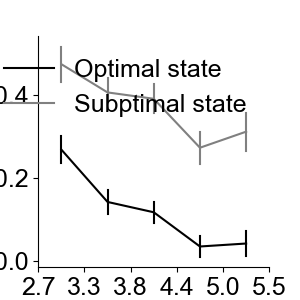

In [18]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)
fig.set_size_inches(3, 3)
plt.rcParams.update({'font.size': font_size})
# multiple line plot    
sns.lineplot(x='action_gap_bin', y='firstUndo', 
             data = firstUndo_sub,
             hue = "error",
             palette = color_palette,
             err_style = "bars",
             errorbar = "se")

# only use 1 decimal place
cutoff_round = [round(i,1) for i in cutoff]
axs.set_xticks(np.arange(0.5, 6.5, 1))
axs.set_xticklabels(cutoff_round)
axs.legend(labels=['Optimal state','Subptimal state'], frameon=False, loc='upper right')

# hide legend
# axs.get_legend().remove()
# axs.set_ylim([0,0.2])
# axs.set_yticks(np.arange(0, 0.25, 0.05))
axs.set(xlabel='Action Gap', ylabel='Probability of Undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_action_gap'+save_mode, dpi=300, bbox_inches='tight')
plt.show()

In [21]:
%%R 

model_undo = lme4::glmer(firstUndo ~  1 + action_gap*error + (1 |subjects)+(1|puzzleID),
                                  data = state_df_1undo, family = binomial(link="logit"))

# save(model_undo, state_df_1undo, file=file.path(out_dir2, file=paste("model_undo_rt1.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + action_gap * error + (1 | subjects) + (1 | puzzleID)
   Data: state_df_1undo

     AIC      BIC   logLik deviance df.resid 
  3038.8   3076.8  -1513.4   3026.8     4152 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4570 -0.3637 -0.1404  0.0684  8.5662 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 7.2065   2.6845  
 puzzleID (Intercept) 0.2388   0.4886  
Number of obs: 4158, groups:  subjects, 100; puzzleID, 46

Fixed effects:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)            3.0744     0.8141   3.777 0.000159 ***
action_gap            -1.7399     0.2152  -8.086 6.15e-16 ***
errorTRUE             -1.5834     0.7569  -2.092 0.036433 *  
action_gap:errorTRUE   1.1334     0.2119   5.349 8.86e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.

# Number of connected cities

In [11]:
%%R -i state_df_1undo,out_dir2
state_df_1undo$subjects <- as.factor(state_df_1undo[,"subjects"])
state_df_1undo$puzzleID <- as.factor(state_df_1undo[,"puzzleID"])

model_undo = lme4::glmer(firstUndo ~  1 + currNumCities + (1 |subjects)+(1|puzzleID),
                                  data = state_df_1undo[state_df_1undo$cumulative_error==0,], family = binomial(link="logit"))

# save(model_undo, state_df_1undo, file=file.path(out_dir2, file=paste("model_undo_rt1.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + currNumCities + (1 | subjects) + (1 | puzzleID)
   Data: state_df_1undo[state_df_1undo$cumulative_error == 0, ]

     AIC      BIC   logLik deviance df.resid 
  1059.6   1081.7   -525.8   1051.6     1843 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4616 -0.2608 -0.1137 -0.0469  6.8354 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 8.7084   2.9510  
 puzzleID (Intercept) 0.9124   0.9552  
Number of obs: 1847, groups:  subjects, 99; puzzleID, 45

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)     5.0622     1.6003   3.163  0.00156 ** 
currNumCities  -1.0569     0.1911  -5.531 3.19e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
currNumCits -0.962


# Context RPE

## check the correlation between predictors

In [21]:
test = state_df_1undo.loc[state_df_1undo.cumulative_error==0,:]
# print(spearmanr(test.groupby(['subjects'])['cumulative_error'].mean() , test.groupby(['subjects'])['RPE'].mean()))
print(spearmanr(test.groupby(['subjects'])['currNumCities'].mean() , test.groupby(['subjects'])['RPE'].mean()))
print(spearmanr(state_df_1undo[state_df_1undo.error==False].groupby(['subjects'])['RT1_log'].mean() , state_df_1undo[state_df_1undo.error==False].groupby(['subjects'])['RPE'].mean()))

SpearmanrResult(correlation=0.27554470082699956, pvalue=0.0057718510472138055)
SpearmanrResult(correlation=-0.044823747680890536, pvalue=0.6595402434931723)


## undo

In [24]:
%%R -i state_df_1undo
model0 = lme4::glmer(firstUndo ~  1 + currNumCities + (1 |subjects) + (1|puzzleID),
                                  data = state_df_1undo[state_df_1undo$cumulative_error==0,], family = binomial(link="logit"))
model1 = lme4::glmer(firstUndo ~  1 + RPE + currNumCities + (1 |subjects) + (1|puzzleID),
                                  data = state_df_1undo[state_df_1undo$cumulative_error==0,], family = binomial(link="logit"))
model2 = lme4::glmer(firstUndo ~  1 + avg_numCities_before + currNumCities + (1 |subjects) + (1|puzzleID),
                                  data = state_df_1undo[state_df_1undo$cumulative_error==0,], family = binomial(link="logit"))
print(summary(model0))
print(summary(model1))
print(summary(model2))
# save(model_undo, state_df_1undo, file=file.path(out_dir2, file=paste("model_undo_rt1.RData", sep="")))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + currNumCities + (1 | subjects) + (1 | puzzleID)
   Data: state_df_1undo[state_df_1undo$cumulative_error == 0, ]

     AIC      BIC   logLik deviance df.resid 
  1044.5   1066.5   -518.2   1036.5     1821 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5462 -0.2579 -0.1149 -0.0474  6.7645 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 8.6307   2.9378  
 puzzleID (Intercept) 0.9523   0.9759  
Number of obs: 1825, groups:  subjects, 99; puzzleID, 45

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)     5.0965     1.6269   3.133  0.00173 ** 
currNumCities  -1.0626     0.1944  -5.467 4.58e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
currNumCits -0.963
Generalized linear mixed model fit

In [23]:
%%R
# model comparison
anova(model0, model1)

Data: state_df_1undo[state_df_1undo$cumulative_error == 0, ]
Models:
model0: firstUndo ~ 1 + currNumCities + (1 | subjects) + (1 | puzzleID)
model1: firstUndo ~ 1 + RPE + currNumCities + (1 | subjects) + (1 | puzzleID)
       npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)
model0    4 1044.5 1066.5 -518.24   1036.5                     
model1    5 1046.5 1074.0 -518.23   1036.5 0.0122  1      0.912
